In [3]:
# Set download directory
import os

current_directory = os.getcwd()
while not current_directory.endswith('pneumonia_detection'):
    current_directory = os.path.dirname(current_directory)
root_directory = current_directory
os.chdir(root_directory)   
os.environ['KAGGLEHUB_CACHE'] = os.path.join(root_directory, 'data')

In [2]:
import kagglehub

# Download latest version
raw_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", raw_path)

/Users/quangnguyen/Code/pneumonia_detection/env/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/quangnguyen/Code/pneumonia_detection/data/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
# Convert to relative path starting from data/
raw_path = os.path.relpath(raw_path, root_directory)

import json

config_path = os.path.join(root_directory, 'src', 'utils', 'config.json')

# Load existing config or create empty one
if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        config = json.load(f)
else:
    config = {}

config['raw_path'] = raw_path

with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)

print(f"Config saved to: {config_path}")

## Check number of files in train, test, and validation sets

In [10]:
def list_folder(folder_path):
    list_of_files = []
    with os.scandir(folder_path) as entries:
        for entry in entries:
            if entry.is_file():
                list_of_files.append(entry.name)

    return list_of_files

### Check number of files in train sets

In [24]:
normal_lungs = [[], [] , []]
pneumonia_lungs = [[], [], []]

In [25]:
data_paths = {
    'train': {
        'NORMAL': os.path.join(raw_path, 'chest_xray', 'train', 'NORMAL'),
        'PNEUMONIA': os.path.join(raw_path, 'chest_xray', 'train', 'PNEUMONIA')
    },
    'val': {
        'NORMAL': os.path.join(raw_path, 'chest_xray', 'val', 'NORMAL'),
        'PNEUMONIA': os.path.join(raw_path, 'chest_xray', 'val', 'PNEUMONIA')
    },
    'test': {
        'NORMAL': os.path.join(raw_path, 'chest_xray', 'test', 'NORMAL'),
        'PNEUMONIA': os.path.join(raw_path, 'chest_xray', 'test', 'PNEUMONIA')
    }
}

In [26]:
file_names = {
    'train': {
        'NORMAL': [],
        'PNEUMONIA': []
    },
    'val': {
        'NORMAL': [],
        'PNEUMONIA': []
    },
    'test': {
        'NORMAL': [],
        'PNEUMONIA': []
    }
}

In [27]:
file_names['train']['NORMAL'] = list_folder(data_paths['train']['NORMAL'])
file_names['train']['PNEUMONIA'] = list_folder(data_paths['train']['PNEUMONIA'])
len(file_names['train']['NORMAL']) , len(file_names['train']['PNEUMONIA'])

(1341, 3875)

### Check number of files in val sets

In [28]:
file_names['val']['NORMAL'] = list_folder(data_paths['val']['NORMAL'])
file_names['val']['PNEUMONIA'] = list_folder(data_paths['val']['PNEUMONIA'])
len(file_names['val']['NORMAL']) , len(file_names['val']['PNEUMONIA'])

(8, 8)

### Check number of files in test sets

In [29]:
file_names['test']['NORMAL'] = list_folder(data_paths['test']['NORMAL'])
file_names['test']['PNEUMONIA'] = list_folder(data_paths['test']['PNEUMONIA'])
len(file_names['test']['NORMAL']) , len(file_names['test']['PNEUMONIA'])

(234, 390)

In [30]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [31]:
def show_images_in_3x3_grid(images, title_prefix='Image', header_title=None):
    num_images = len(images)
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 15)) 
    
    if header_title:
        fig.suptitle(header_title, fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            # Hiển thị ảnh
            ax.imshow(images[i], cmap='gray')
            ax.set_title(f'{title_prefix} {i+1}')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## PREPROCESSING

### Convert to GrayScale

In [32]:
PREPROCESS_DATADIR = os.path.join(root_directory, 'data_processed')

In [33]:
src_dest_pairs = []

In [34]:
for dataset_type in ['train', 'val', 'test']:
    for category in ['NORMAL', 'PNEUMONIA']:
        raw_folder_path = data_paths[dataset_type][category]
        preprocessed_folder_path = os.path.join(PREPROCESS_DATADIR, dataset_type, category)
        os.makedirs(preprocessed_folder_path, exist_ok=True)
        for file_name in file_names[dataset_type][category]:
            file_path = os.path.join(raw_folder_path, file_name)
            preprocessed_file_path = os.path.join(preprocessed_folder_path, file_name)
            src_dest_pairs.append((file_path, preprocessed_file_path))

In [35]:
len(src_dest_pairs)

5856

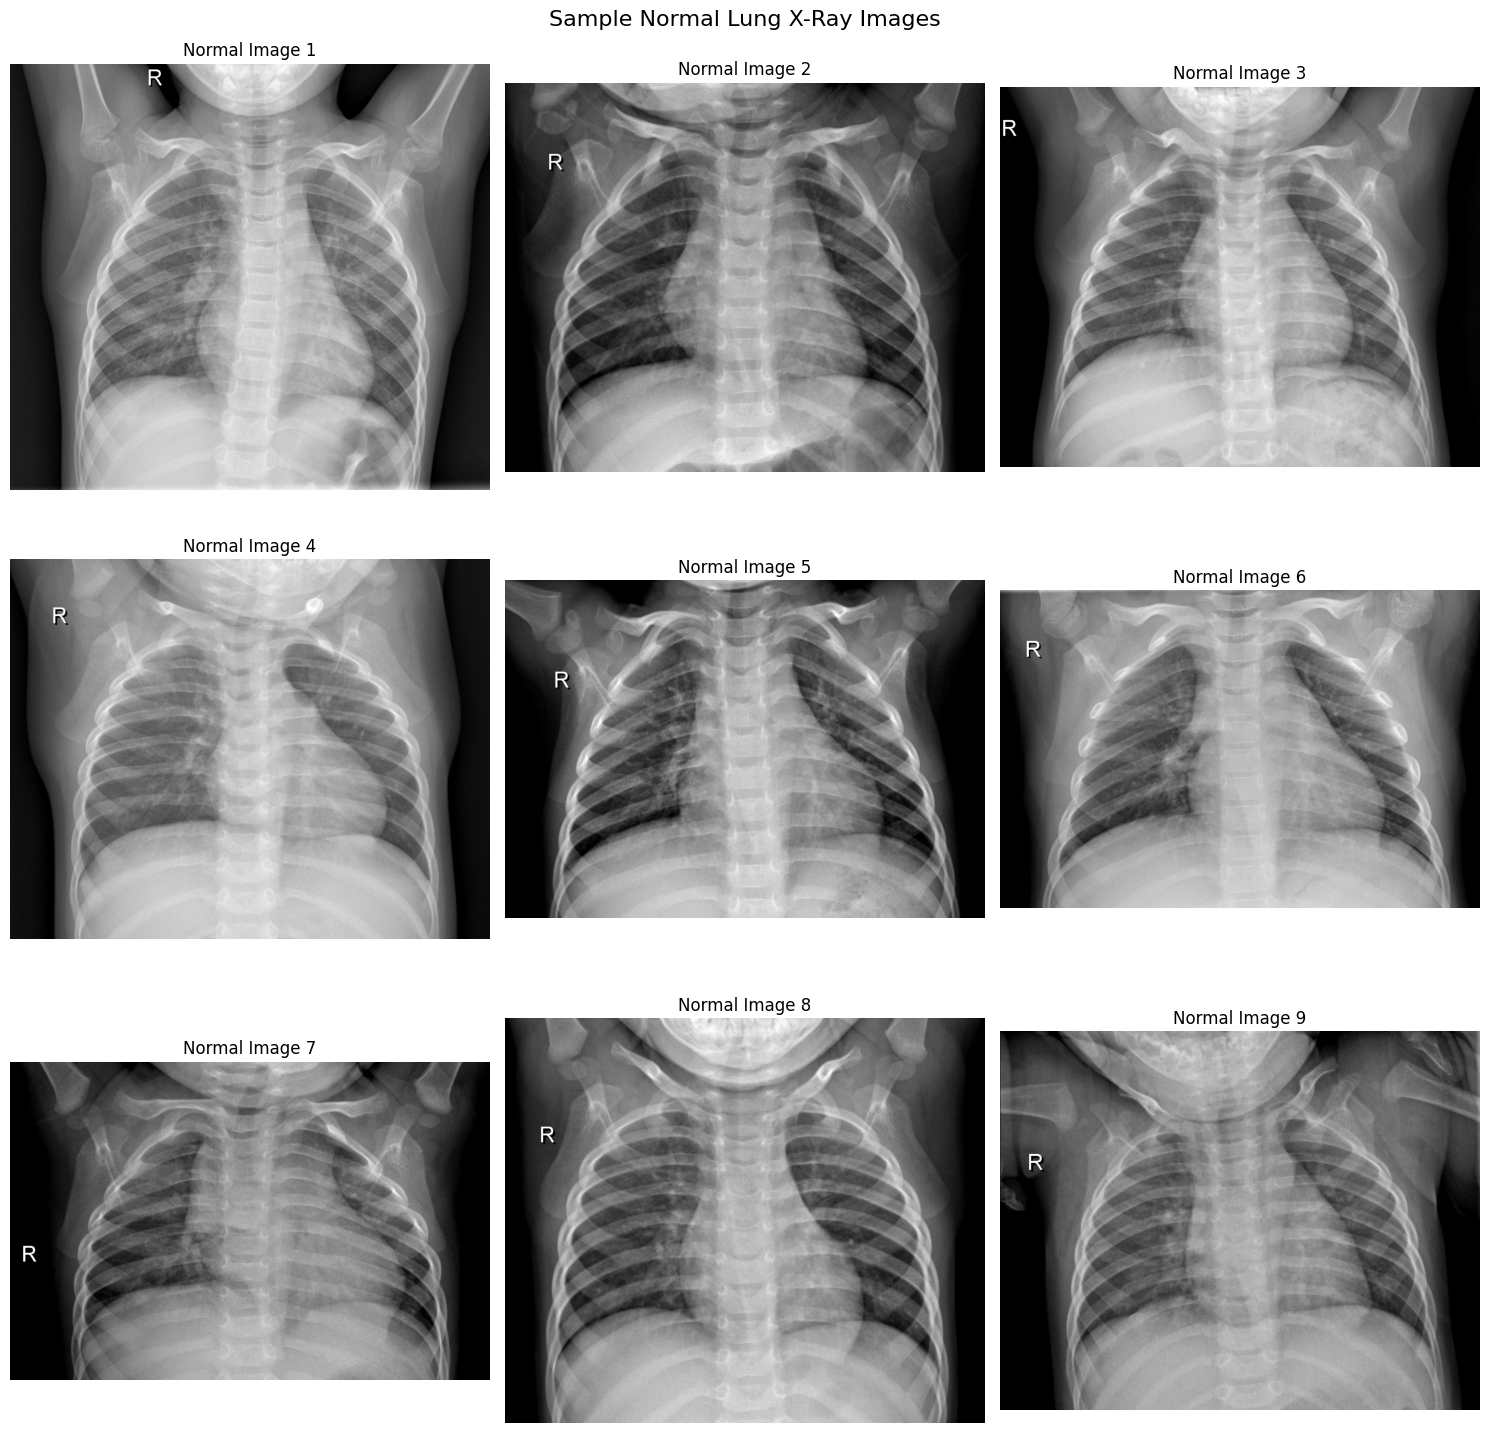

In [36]:
normal_raw_images = []
for file_path, _ in src_dest_pairs:
    if 'NORMAL' in file_path:
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        normal_raw_images.append(image)
    if len(normal_raw_images) >= 9:
        break

show_images_in_3x3_grid(normal_raw_images, title_prefix='Normal Image', header_title='Sample Normal Lung X-Ray Images')

## NORMAL Images After Preprocessing

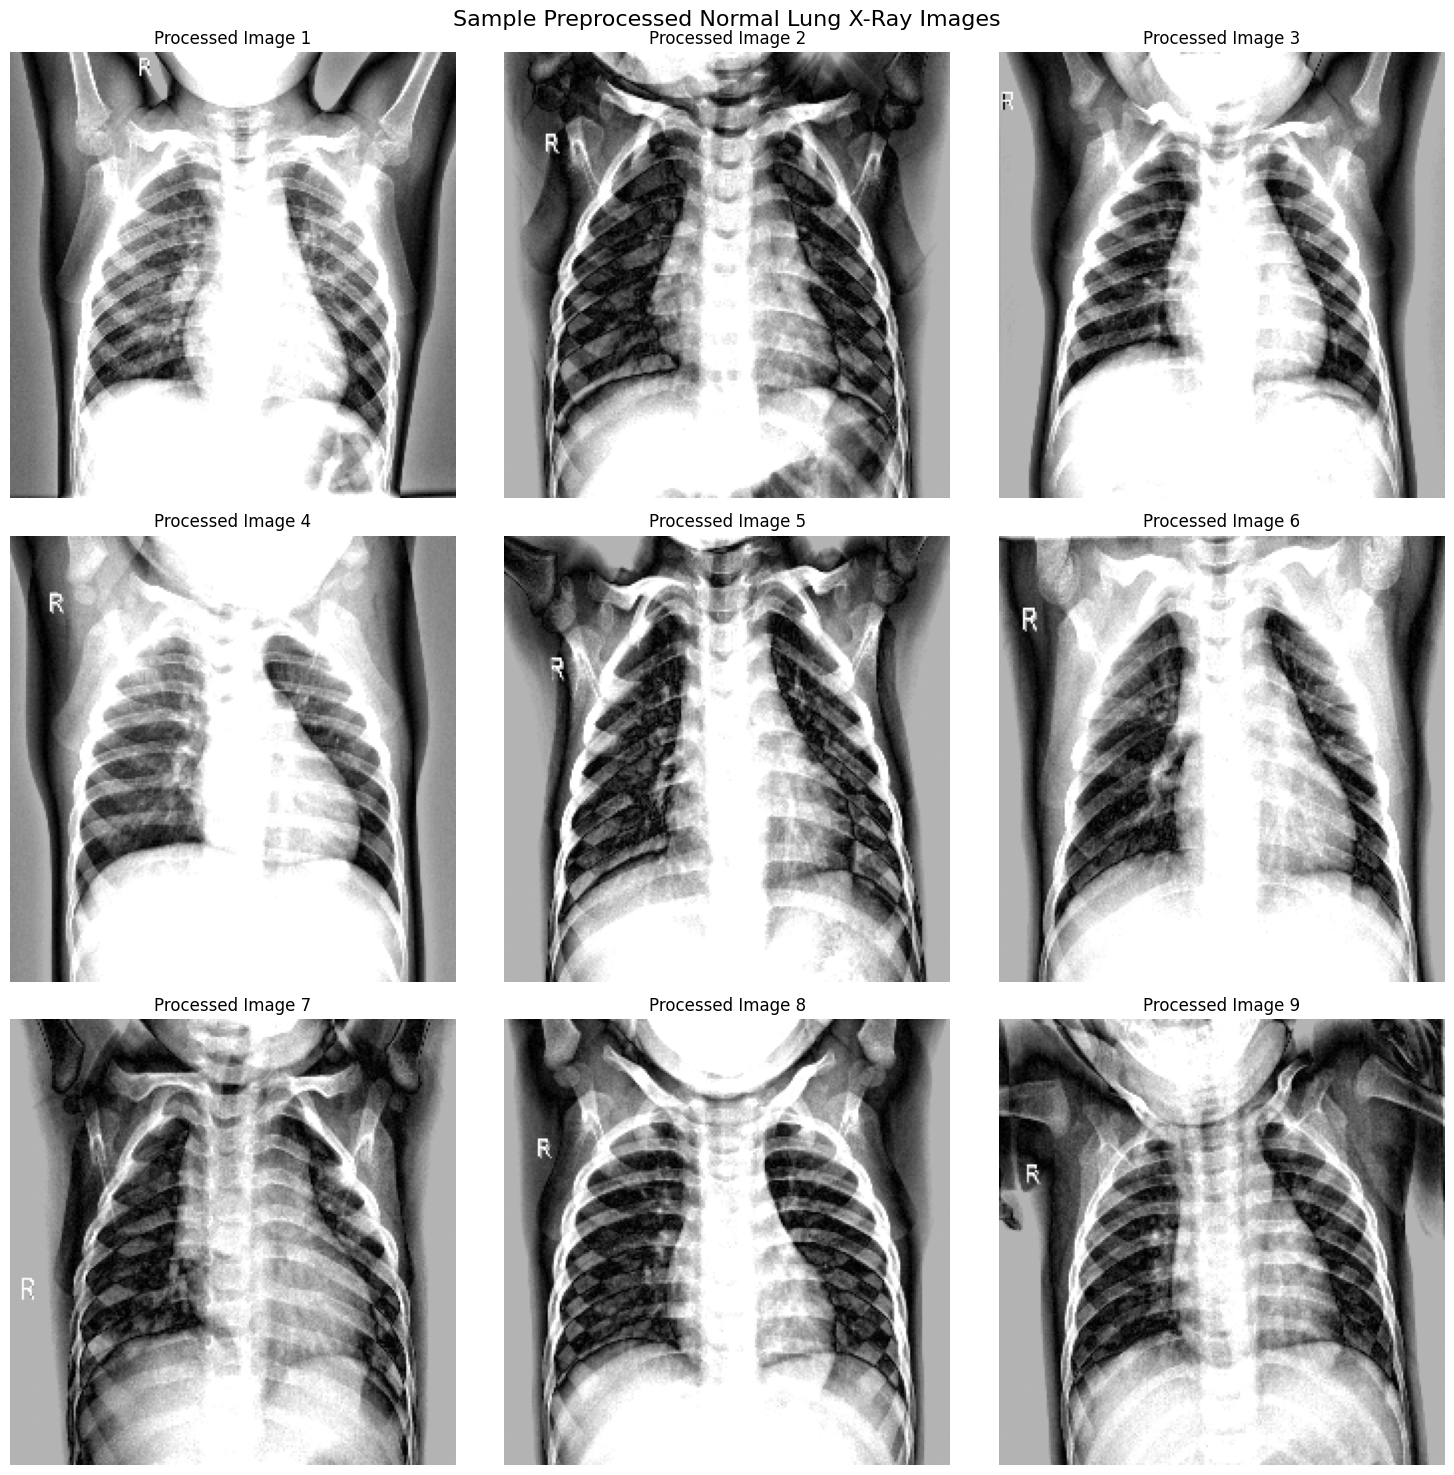

In [37]:
# Demo 9 images
processed_images = []

cnt = 0
# Ensure the loop runs at most 9 times
for file_path, preprocessed_file_path in src_dest_pairs:
    if cnt >= 9:
        break
    if 'NORMAL' not in file_path:
        continue
    # read image
    image = cv2.imread(file_path)

    # Check if the image was successfully read
    if image is None:
        print(f"Error: Unable to read image file at {file_path}")
        continue
        
    image = cv2.resize(image, (224, 224))
    # 1. Convert image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    alpha_contrast = 2.5
    beta_brightness = -180

    # Adjust Contrast and Brightness
    image_float = image.astype(np.float32)
    image_adjusted = cv2.convertScaleAbs(image_float, alpha=alpha_contrast, beta=beta_brightness)
    
    # Adjust Gamma
    gamma = 1
    # Create Gamma lookup table
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)]).astype("uint8")
    image_gamma = cv2.LUT(image_adjusted, table)
    image = image_gamma
    
    # Collect processed images
    processed_images.append(image)
    
    cnt += 1

show_images_in_3x3_grid(processed_images, title_prefix='Processed Image', header_title='Sample Preprocessed Normal Lung X-Ray Images')

## PNEUMONIA Images before Preprocessing

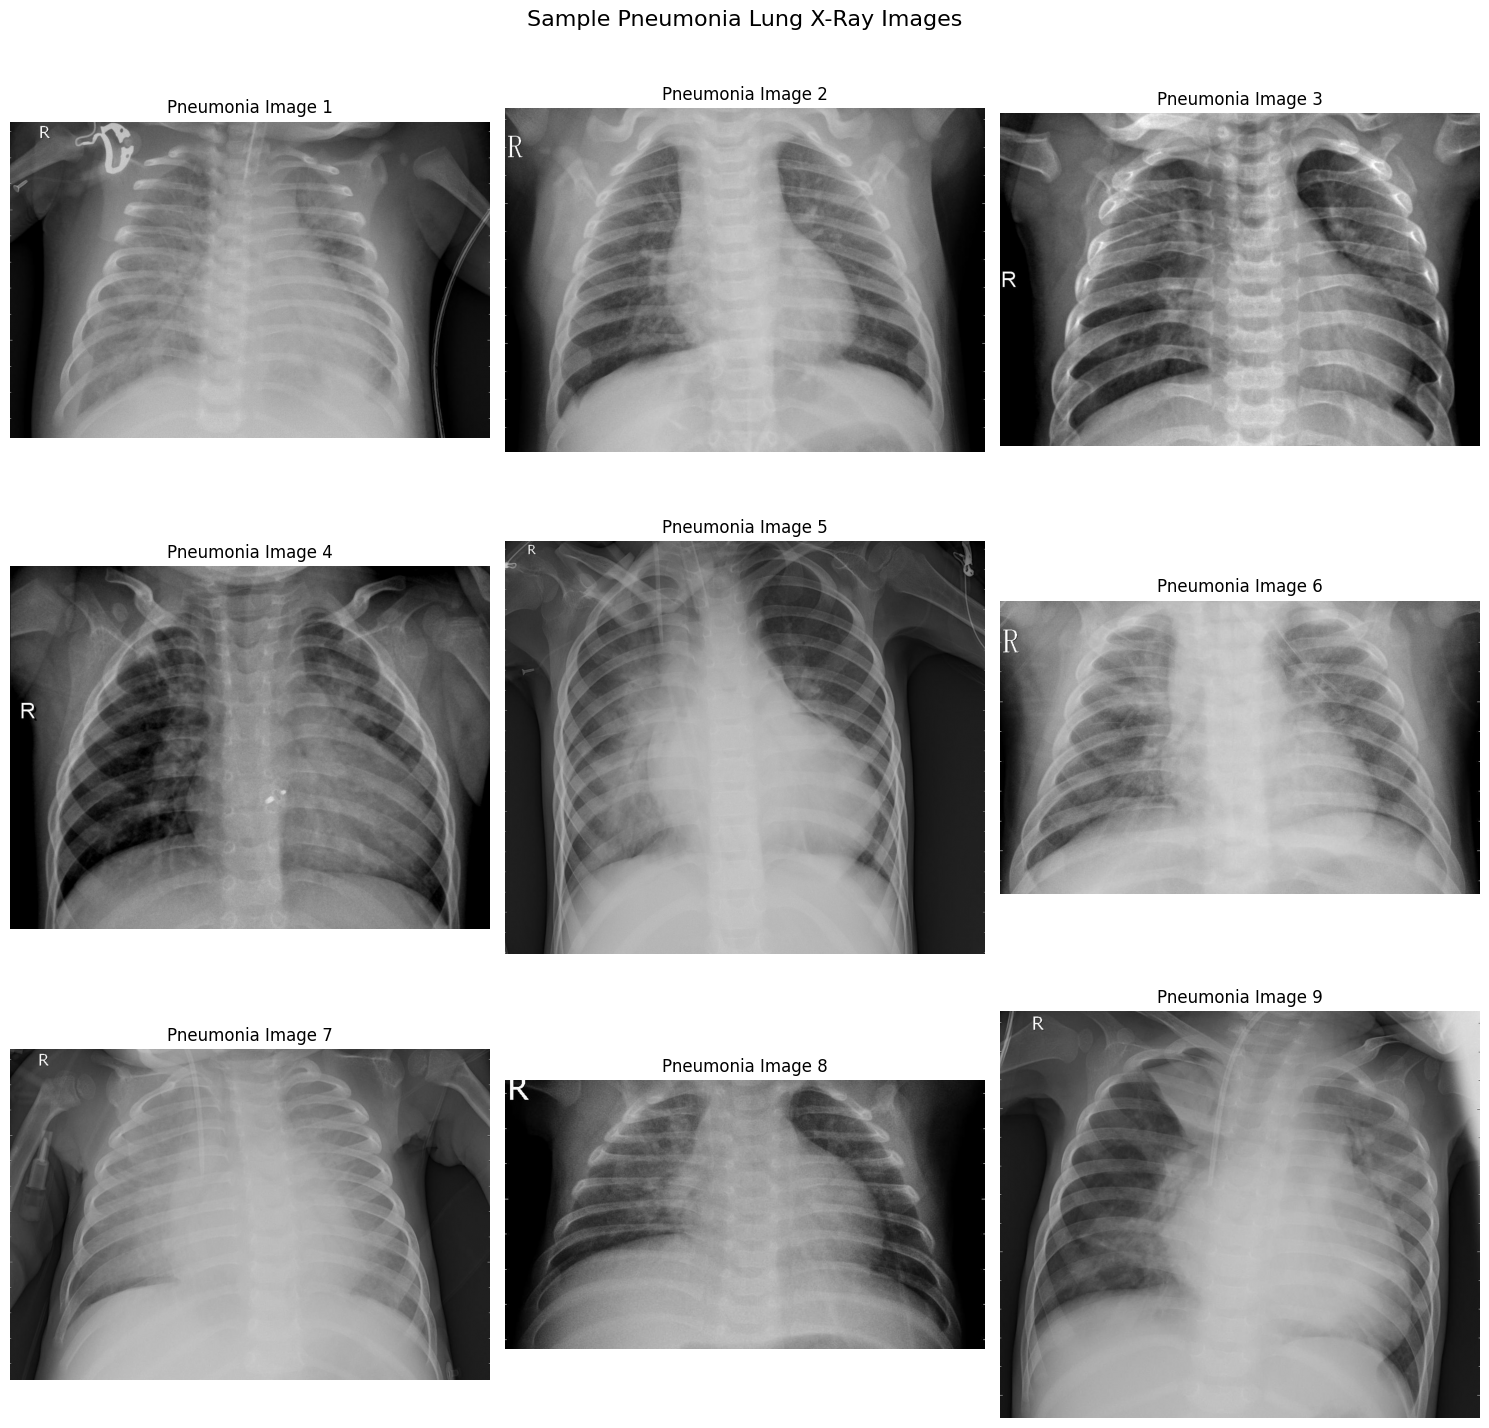

In [38]:
pneumonia_raw_images = []
for file_path, _ in src_dest_pairs:
    if 'PNEUMONIA' in file_path:
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneumonia_raw_images.append(image)
    if len(pneumonia_raw_images) >= 9:
        break

show_images_in_3x3_grid(pneumonia_raw_images, title_prefix='Pneumonia Image', header_title='Sample Pneumonia Lung X-Ray Images')

## PNEUMONIA Images After Preprocessing

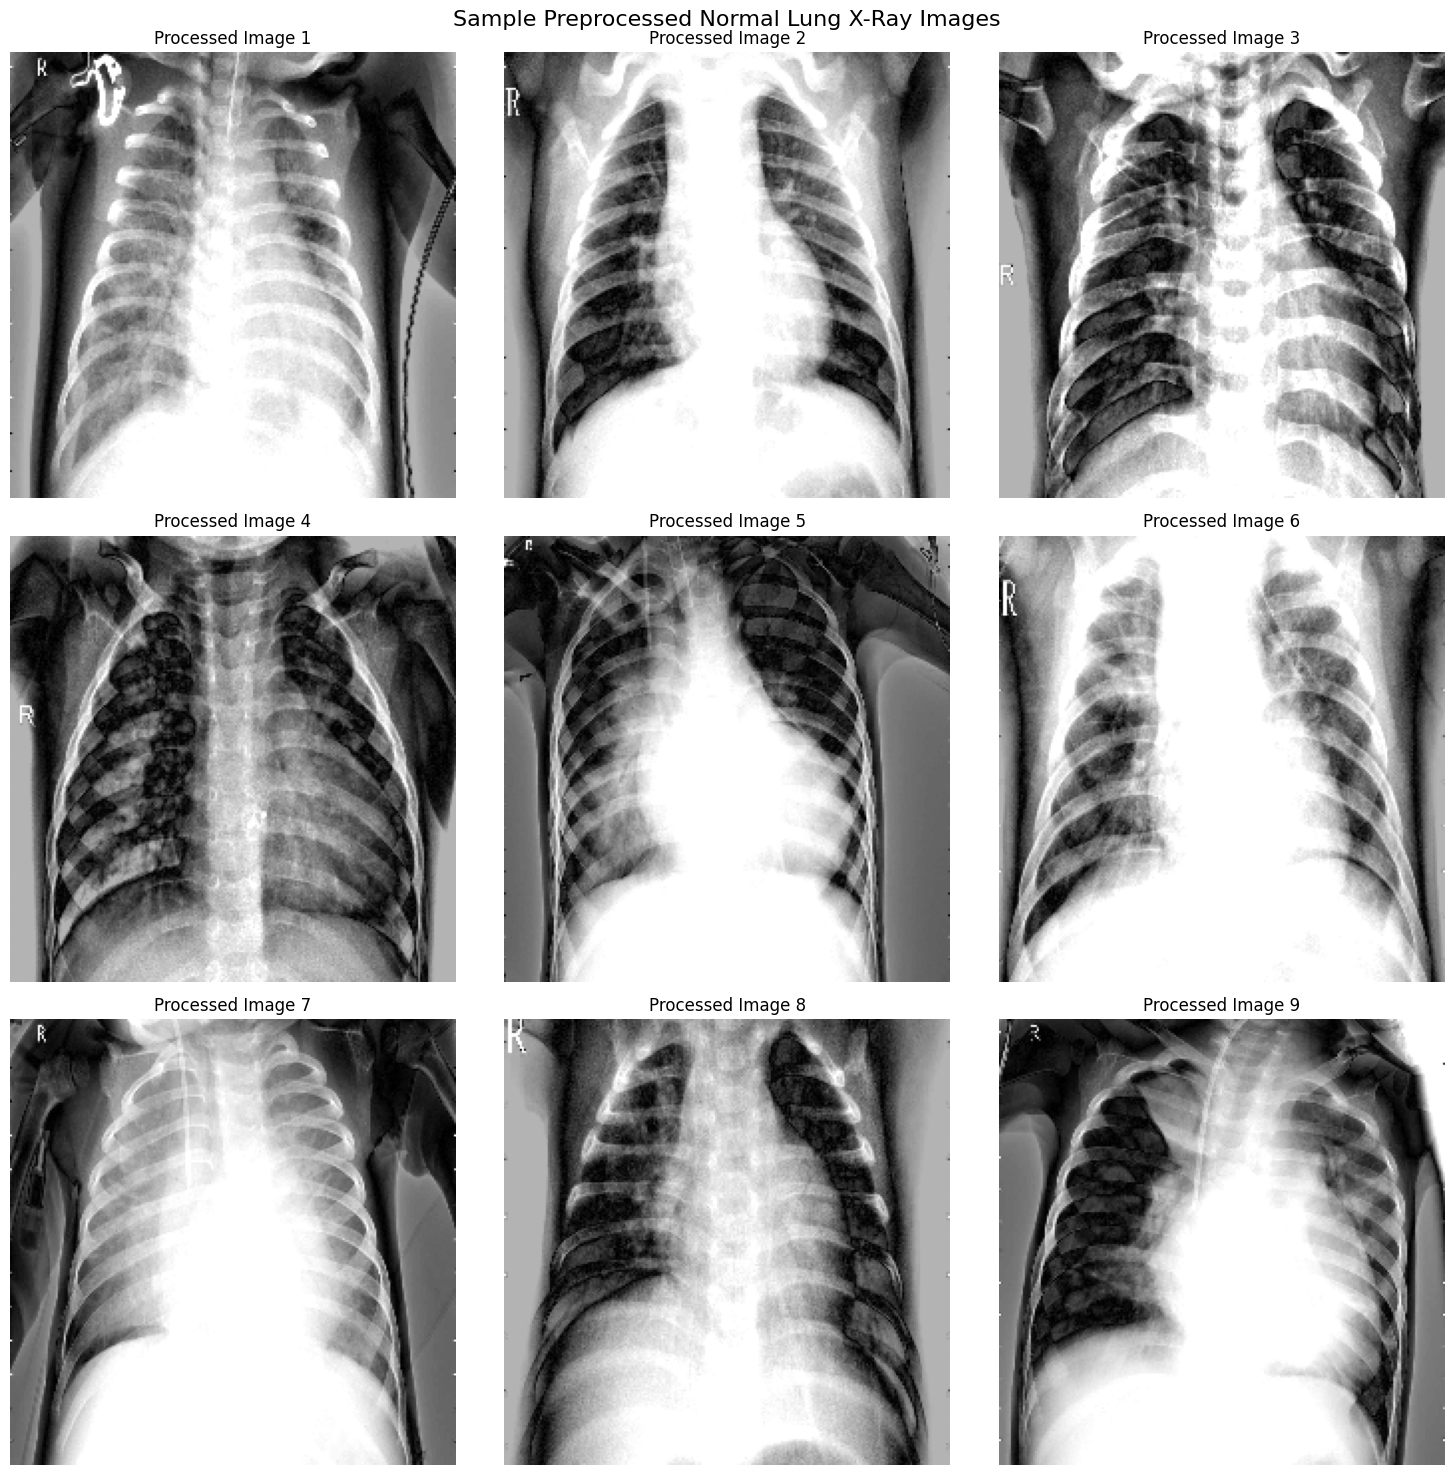

In [39]:
# Demo 9 images
processed_images = []

cnt = 0
for file_path, preprocessed_file_path in src_dest_pairs:
    if cnt >= 9:
        break
    if 'PNEUMONIA' not in file_path:
        continue
    # read image
    image = cv2.imread(file_path)

    # Check if the image was successfully read
    if image is None:
        print(f"Error: Unable to read image file at {file_path}")
        continue
        
    image = cv2.resize(image, (224, 224))
    # Convert image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    alpha_contrast = 2.5
    beta_brightness = -180

    # Adjust Contrast and Brightness
    image_float = image.astype(np.float32)
    image_adjusted = cv2.convertScaleAbs(image_float, alpha=alpha_contrast, beta=beta_brightness)
    
    # Adjust Gamma
    gamma = 1
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)]).astype("uint8")
    image_gamma = cv2.LUT(image_adjusted, table)
    image = image_gamma

    processed_images.append(image)
    
    cnt += 1

show_images_in_3x3_grid(processed_images, title_prefix='Processed Image', header_title='Sample Preprocessed Normal Lung X-Ray Images')

## PREPROCESSING ALL IMAGES AND SAVE TO DISK

In [40]:
## PREPROCESSING ALL IMAGES AND SAVE TO DISK
for file_path, preprocessed_file_path in src_dest_pairs:
    # read image
    image = cv2.imread(file_path)

    # Check if the image was successfully read
    if image is None:
        print(f"Error: Unable to read image file at {file_path}")
        continue
        
    image = cv2.resize(image, (224, 224))
    # 1. Convert image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    alpha_contrast = 2.5
    beta_brightness = -180

    # Adjust Contrast and Brightness
    image_float = image.astype(np.float32)
    image_adjusted = cv2.convertScaleAbs(image_float, alpha=alpha_contrast, beta=beta_brightness)
    
    # Adjust Gamma
    gamma = 1
    # Create Gamma lookup table
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)]).astype("uint8")
    image_gamma = cv2.LUT(image_adjusted, table)
    image = image_gamma
    
    # Save preprocessed image to disk
    cv2.imwrite(preprocessed_file_path, image)